In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
df = pd.read_csv('PGA_winnings.csv')
# score = 0, no data
df = df[~(df['SCORE']==0)]
df.head(10)

,SEASON,NAME,AGE,EARNINGS,CUP,EVNTS,RNDS,CUTS,TOP10,WINS,SCORE,DDIS,DACC,GIR,PUTTS,SAND,BIRDS
56,2023,Scottie Scheffler,27,"$21,014,342",4218,23,88,23,17,2,68.3,310.3,62.1,74.4,1.735,44.2,4.409
57,2023,Jon Rahm,29,"$16,522,608",3486,20,71,18,10,4,68.8,314.0,57.7,70.5,1.711,49.5,4.493
59,2023,Viktor Hovland,26,"$14,112,235",4024,23,88,23,9,3,68.9,307.6,63.7,68.2,1.716,58.3,4.409
60,2022,Scottie Scheffler,27,"$14,046,910",-20,25,84,20,11,4,68.9,311.6,60.0,72.3,1.720,49.5,4.595
68,2023,Rory McIlroy,34,"$13,921,008",3494,18,64,16,13,2,68.9,326.3,53.3,67.9,1.730,50.6,4.297
74,2023,Max Homa,33,"$10,761,517",2871,25,86,21,13,2,69.2,304.8,60.1,66.9,1.699,55.6,4.337
78,2023,Wyndham Clark,29,"$10,757,490",2157,28,102,24,8,2,69.4,313.5,54.9,67.8,1.727,56.5,4.108
82,2023,Patrick Cantlay,31,"$10,372,998",2843,21,72,18,10,0,68.8,308.6,65.5,69.8,1.723,47.3,4.500
85,2022,Cameron Smith,30,"$10,107,897",-9,18,62,14,7,3,68.9,299.7,57.5,68.0,1.679,52.2,4.629
86,2022,Will Zalatoris,27,"$9,405,082",3680,24,76,17,9,1,69.6,314.7,55.4,70.9,1.734,49.0,4.316


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 56 to 492
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEASON    381 non-null    int64  
 1   NAME      381 non-null    object 
 2   AGE       381 non-null    int64  
 3   EARNINGS  381 non-null    object 
 4   CUP       381 non-null    int64  
 5   EVNTS     381 non-null    int64  
 6   RNDS      381 non-null    int64  
 7   CUTS      381 non-null    int64  
 8   TOP10     381 non-null    int64  
 9   WINS      381 non-null    int64  
 10  SCORE     381 non-null    float64
 11  DDIS      381 non-null    float64
 12  DACC      381 non-null    float64
 13  GIR       381 non-null    float64
 14  PUTTS     381 non-null    float64
 15  SAND      381 non-null    float64
 16  BIRDS     381 non-null    float64
dtypes: float64(7), int64(8), object(2)
memory usage: 53.6+ KB


In [4]:
df.sort_values(by='EARNINGS')

,SEASON,NAME,AGE,EARNINGS,CUP,EVNTS,RNDS,CUTS,TOP10,WINS,SCORE,DDIS,DACC,GIR,PUTTS,SAND,BIRDS
369,2022,Nick Watney,42,"$1,012,572",387,30,76,10,1,0,71.7,301.2,53.7,66.8,1.806,46.6,3.263
368,2023,Kramer Hickok,31,"$1,017,832",236,34,97,16,0,0,70.4,296.7,63.4,68.6,1.790,52.9,3.454
367,2022,Charles Howell III,44,"$1,026,002",400,16,54,11,1,0,69.7,304.1,61.8,71.0,1.758,60.0,4.185
366,2022,Stewart Cink,50,"$1,026,158",376,25,77,13,2,0,70.7,306.2,59.8,68.3,1.772,51.0,3.662
365,2022,Scott Piercy,45,"$1,030,752",410,28,77,13,1,0,70.5,295.8,56.7,62.6,1.738,50.0,3.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,2023,Austin Smotherman,29,"$957,049",293,35,100,17,1,0,70.4,300.4,62.6,66.4,1.758,45.7,3.940
373,2022,Nate Lashley,40,"$976,895",427,25,76,13,1,0,70.0,295.2,63.6,67.7,1.733,45.1,4.039
372,2022,Patton Kizzire,37,"$985,293",351,29,90,17,1,0,70.5,303.7,55.9,65.6,1.767,51.9,3.722
371,2023,Charley Hoffman,46,"$994,186",246,31,81,12,0,0,70.3,306.1,55.7,68.4,1.797,52.0,3.679


In [5]:
# pre-processing
df['EARNINGS'] = df['EARNINGS'].replace('[\$,]', '', regex=True).astype(int)

## **Exploratory Data Analysis**

**Visualizing the relationship of features against Earnings**

- Score (SCORE) vs Earnings: As average score increases, earnings decrease

- Driving Distance (DDIS) vs Earnings: Higher average driving distance correlates to higher earnings

- Average Putts (PUTTS) vs Earnings: A lower average putt correlates to higher earnings

- Greens in Regulations (GIR) vs Earnings: As greens in regulation % increases, earnings increase

- Birdies per Round (BIRDS) vs Earnings: More birdies per round correlates to higher earnings

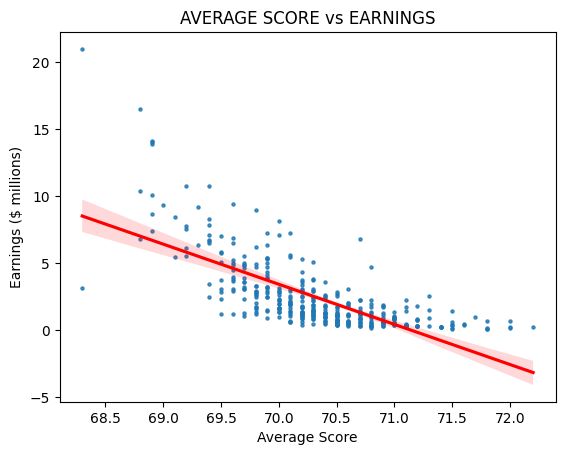

In [6]:
sns.regplot(x=df['SCORE'], y=df['EARNINGS']/1000000, scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xlabel('Average Score')
plt.ylabel('Earnings ($ millions)') 
#plt.yscale('log') 
plt.title('AVERAGE SCORE vs EARNINGS')
plt.show()

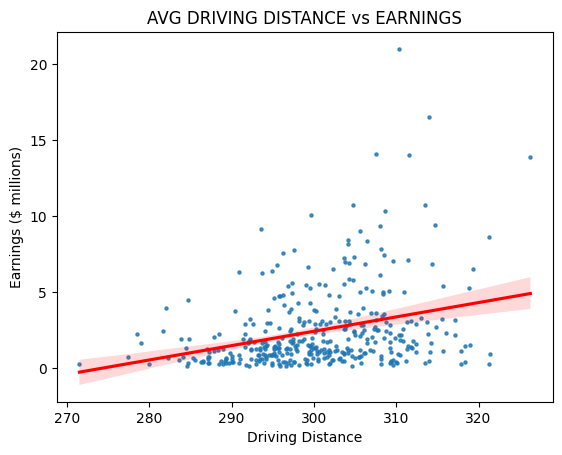

In [7]:
sns.regplot(x=df['DDIS'], y=df['EARNINGS']/1000000, scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xlabel('Driving Distance')
plt.ylabel('Earnings ($ millions)') 
#plt.yscale('log') 
plt.title('AVG DRIVING DISTANCE vs EARNINGS')
plt.show()

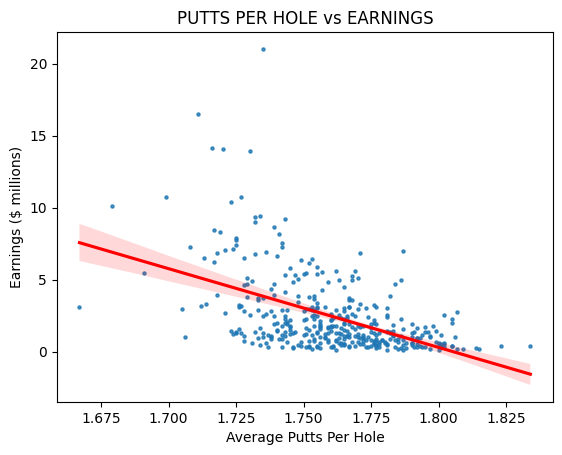

In [8]:
sns.regplot(x=df['PUTTS'], y=df['EARNINGS']/1000000, scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xlabel('Average Putts Per Hole')
plt.ylabel('Earnings ($ millions)') 
#plt.yscale('log') 
plt.title('PUTTS PER HOLE vs EARNINGS')
plt.show()

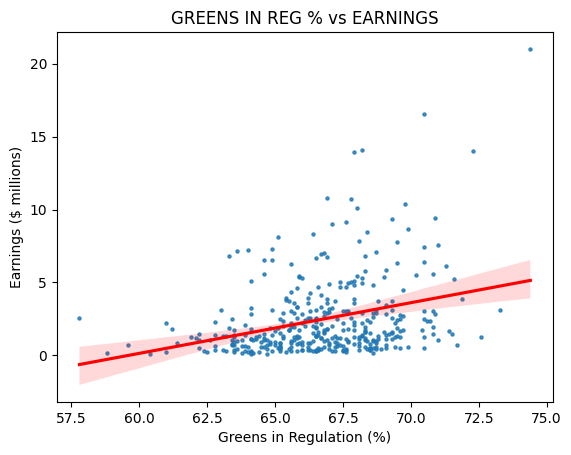

In [9]:
#plt.scatter(df['GIR'], df['EARNINGS'], s=10)
sns.regplot(x=df['GIR'], y=df['EARNINGS']/1000000, scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xlabel('Greens in Regulation (%)')
plt.ylabel('Earnings ($ millions)') 
#plt.yscale('log') 
plt.title('GREENS IN REG % vs EARNINGS')
plt.show()

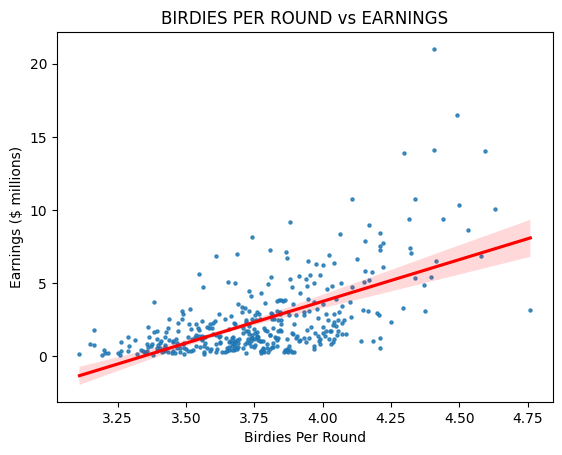

In [10]:
sns.regplot(x=df['BIRDS'], y=df['EARNINGS']/1000000, scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xlabel('Birdies Per Round')
plt.ylabel('Earnings ($ millions)') 
#plt.yscale('log') 
plt.title('BIRDIES PER ROUND vs EARNINGS')
plt.show()

## **Modeling**

Extreme Gradient Boosting (XGBoost) vs. Random Forest

Using K-Fold Cross Validation, with k = 5 folds, we will evaluate the models using root mean squared error (RMSE) and R-squared. RMSE tells us how much error our model averages in predicting earnings, while R-squared tells us how much variance is explained in our mdoel for predicting Earnings. The standard deviation over all folds of the data for both scoring metrics will also be considered, we should expect the standard deviation to decrease after tuning the model.

In [11]:
drop_cols = ['SEASON', 'NAME', 'EARNINGS', 'CUP', 'EVNTS', 'RNDS', 'CUTS', 'TOP10', 'WINS']

X = df.drop(columns=drop_cols)
y = df['EARNINGS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [12]:
xgb_mod = xgb.XGBRegressor()
xgb_mod.fit(X_train, y_train)

y_pred = xgb_mod.predict(X_test)


In [13]:
# Define the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Calculate cross-validated scores
scores = cross_val_score(xgb_mod, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"Mean cross-validated RMSE: {np.mean(np.sqrt(-scores))}")
print(f"Standard deviation of cross-validated RMSE: {np.std(np.sqrt(-scores))}")

# cross-validated R-squared
scores = cross_val_score(xgb_mod, X_train, y_train, cv=kfold, scoring='r2')
print(f"Mean cross-validated R-squared: {np.mean(scores)}")
print(f"Standard deviation of cross-validated R-squared: {np.std(scores)}")

Mean cross-validated RMSE: 1930859.602469325
Standard deviation of cross-validated RMSE: 426797.9628417632
Mean cross-validated R-squared: 0.4772262279073571
Standard deviation of cross-validated R-squared: 0.2290677066570719


Now, I'm going to tune several of the hyper parameters of the XGBoost model.

In [14]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.02, .03],
    'max_depth': [2, 3, 4],
    'n_estimators': [80, 100, 120],
    'reg_alpha': [0.1, 0.2, 0.3],
}

# Create the GridSearchCV object
xgb_grid = GridSearchCV(estimator=xgb_mod, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the training data
xgb_grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = xgb_grid.best_params_

# Print the best hyperparameters
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.2}


In [15]:
# Create a new XGBRegressor with the best parameters
xgb_best = xgb.XGBRegressor(**best_params)

# Fit the model with the best parameters on the entire training data
xgb_best.fit(X_train, y_train)

y_pred_best = xgb_best.predict(X_test)

# Define the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Calculate cross-validated scores
scores = cross_val_score(xgb_best, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"Mean cross-validated RMSE: {np.mean(np.sqrt(-scores))}")
print(f"Standard deviation of cross-validated RMSE: {np.std(np.sqrt(-scores))}")

# cross-validated R-squared
scores = cross_val_score(xgb_best, X_train, y_train, cv=kfold, scoring='r2')
print(f"Mean cross-validated R-squared: {np.mean(scores)}")
print(f"Standard deviation of cross-validated R-squared: {np.std(scores)}")

Mean cross-validated RMSE: 1815404.1788084875
Standard deviation of cross-validated RMSE: 190584.70183567455
Mean cross-validated R-squared: 0.551350482891617
Standard deviation of cross-validated R-squared: 0.07106132057455503


After tuning, we were able to lower the RMSE from 1.93 million to 1.82 million, and halve the standard deviation. The optimized model also explains more variance in predicting Earnings, before tuning the model had cross-validated R-squared of .477, and after tuning the R-squared improved to .551

We can see that tuning significantly improved the performance of the model.

## **Model Interpretation using Shapley (Shap) Values**

Using Shapley values, we can evaluate our model and determine which features and their values are the most significant in predicting Earnings.

-Results-

Highest predictive power for Earnings:
Lower average score, higher driving distance, lower average putts per hole, lower GIR%, younger ages are all values and features that are most significant for predicting Earnings. They give us the highest accuracy. 

One of the interesting results from the Shapley values explainer visual is the effect of GIR% on earnings. We can see that a lower GIR% correlates to more predictive power for Earnings. A higher GIR% has more variance, meaning the model is not as good at predicting Earnings for players with a high GIR%. In other words, the larger GIR = more variance in earnings.

[16:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


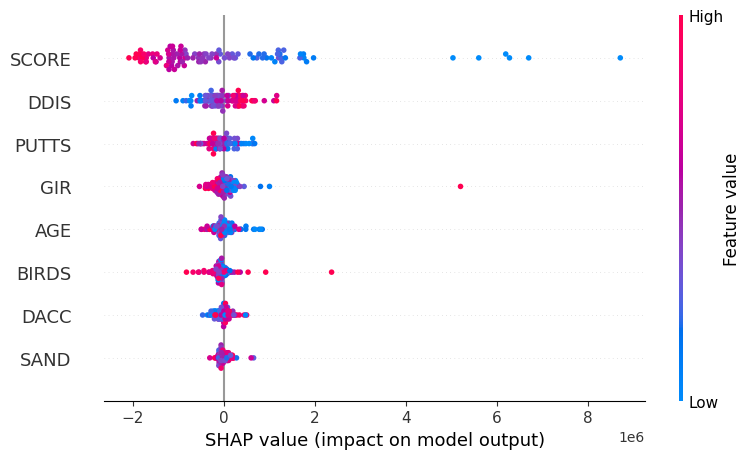

In [16]:
# Create an explainer object
explainer = shap.Explainer(xgb_mod)

# Calculate SHAP values for a sample of your data (e.g., first 100 rows)
shap_values = explainer.shap_values(X_train.iloc[:100, :])

# Summary plot to visualize feature importance
shap.summary_plot(shap_values, X_train.iloc[:100, :])

# Force plot for a specific prediction (replace index with the row you want to explain)
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])

## **Generate predictions for specific players**

Using the row index for a given player in our dataset, we can see what the projected earnings from the model were for that player. For example, we see below Xander Schauffele in 2022 had actual earnings of $7.42 million. Our model projected his earnings to be $7.78 million, which is very close. 

In [17]:
# check models predictions for a specific player
# 10 = Patrick Cantlay (2022), 20 = Xander Schauffele (2022), 50 = Joaquin Niemann (2022)
row_idx = 20
df.iloc[row_idx, :]


SEASON                   2022
NAME        Xander Schauffele
AGE                        30
EARNINGS              7427299
CUP                       -18
EVNTS                      21
RNDS                       72
CUTS                       18
TOP10                       7
WINS                        3
SCORE                    68.9
DDIS                    308.5
DACC                     62.2
GIR                      70.5
PUTTS                   1.725
SAND                     64.9
BIRDS                   4.319
Name: 104, dtype: object

In [18]:
player_example = df.drop(columns=drop_cols)
player_example = player_example.iloc[row_idx, :].values.reshape(1, -1)
xgb_best.predict(player_example)[0]

7780310.5

## **Optional: Experiment with making predictions on custom stats**

In [19]:
# for making predictions on new data, provide data into test_data
# test_data = 
# new_predictions = xgb_mod.predict(test_data)